In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_greedy_policy(Q, nA):
    """
    Creates an greedy policy based on a given Q-function.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation(state) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.zeros(nA, dtype=float) / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += 1.0
        print(f"observation={observation},Q={Q},A={A}")
        return A
    return policy_fn

In [4]:
def mc_control_greedy_policy(env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo Control using Greedy policies.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_greedy_policy(Q, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            # why flush? no effect?
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="", flush=True)
            #sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        # state: (player card sum, deal showing card, useable ase)
        state = env.reset()
        for t in range(100):
            print(f"episode={i_episode},{t}")
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
        # The policy is improved implicitly by changing the Q dictionary
    
    return Q, policy

In [5]:
Q, policy = mc_control_greedy_policy(env, num_episodes=10)

episode=1,0
observation=(15, 6, False),Q=defaultdict(<function mc_control_greedy_policy.<locals>.<lambda> at 0x7ff7aa265bf8>, {(15, 6, False): array([0., 0.])}),A=[1. 0.]
episode=2,0
observation=(15, 9, False),Q=defaultdict(<function mc_control_greedy_policy.<locals>.<lambda> at 0x7ff7aa265bf8>, {(15, 6, False): array([1., 0.]), (15, 9, False): array([0., 0.])}),A=[1. 0.]
episode=3,0
observation=(16, 2, False),Q=defaultdict(<function mc_control_greedy_policy.<locals>.<lambda> at 0x7ff7aa265bf8>, {(15, 6, False): array([1., 0.]), (15, 9, False): array([-1.,  0.]), (16, 2, False): array([0., 0.])}),A=[1. 0.]
episode=4,0
observation=(21, 5, True),Q=defaultdict(<function mc_control_greedy_policy.<locals>.<lambda> at 0x7ff7aa265bf8>, {(15, 6, False): array([1., 0.]), (15, 9, False): array([-1.,  0.]), (16, 2, False): array([-1.,  0.]), (21, 5, True): array([0., 0.])}),A=[1. 0.]
episode=5,0
observation=(18, 1, False),Q=defaultdict(<function mc_control_greedy_policy.<locals>.<lambda> at 0x7ff

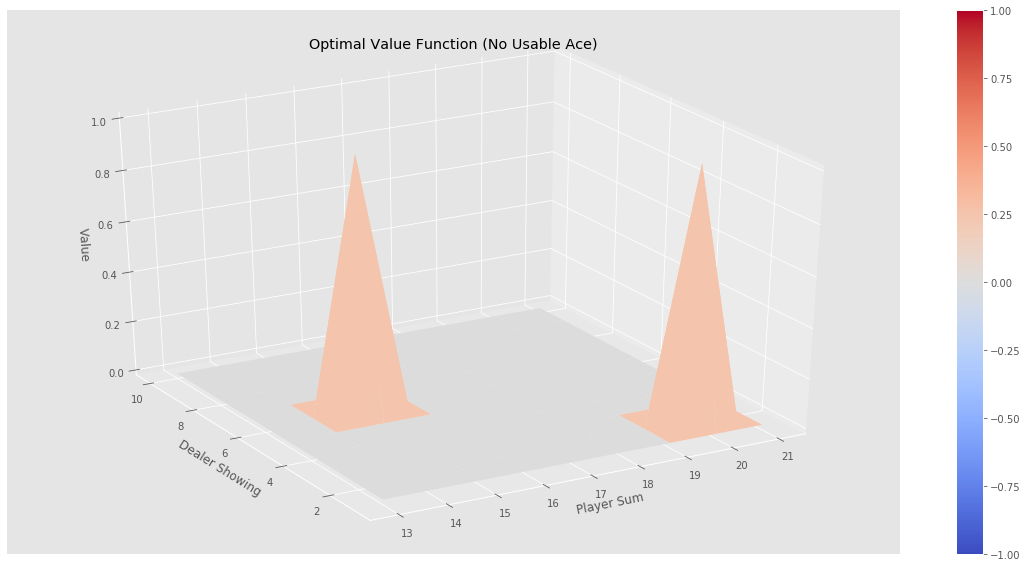

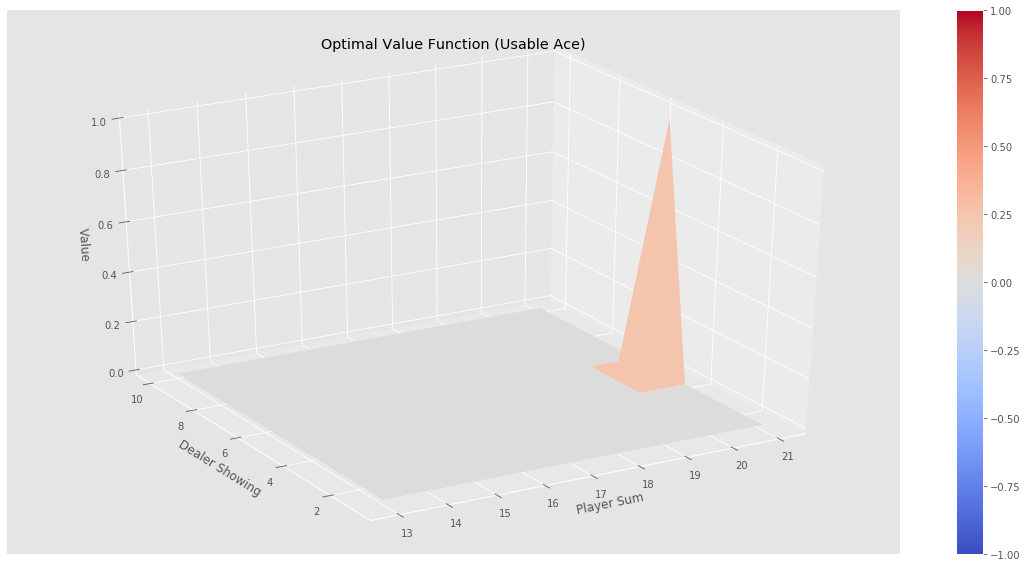

In [6]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

如何打印出optimal policy？